# Analysis

In [2]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

In [502]:
sns.set(rc={'figure.figsize':(10,7)})
plt.style.use('seaborn-whitegrid')

In [503]:
year = 'model_old'

## Data preparation

In [504]:
f = uproot.pandas.iterate("../outputs/"+year+"/trees/*.root", "t", reportpath = True,
                          branches=['beam_energy', 'mass', 'trigger', 'procedure'])

In [505]:
dataRAW = pd.concat([j.assign(name=float(re.findall(r"\d+\.\d+", path)[0])) for path,j in f])

In [506]:
dataRAW.sort_values(by='name', ascending=True, inplace=True);

Количество уникальных `name` в `data` должно совпадать с количеством точек в сезоне

* 11 год: 40 точек
* 12 год: 16 точек
* 17 год: 34 точки
* 19 год: 44 точки
* моделирование: 38 точек

In [507]:
print("Checking:", len(dataRAW.name.unique()), 'different names in', year, 'season')

Checking: 38 different names in model_old season


Проверка типов полей датафрейма

In [508]:
dataRAW.dtypes

beam_energy    float64
mass           float64
trigger          int32
procedure        int32
name           float64
dtype: object

Проверка данных

In [509]:
dataRAW.describe()

,beam_energy,mass,trigger,procedure,name
count,44490.000000,44490.000000,44490.000000,44490.000000,44490.000000
mean,769.736626,428.681215,3.754417,2.078872,769.736626
std,124.504193,171.688190,4.512496,0.588772,124.504193
min,550.000000,-1.000000,-1.000000,1.000000,550.000000
25%,662.500000,487.798431,0.000000,2.000000,662.500000
50%,800.000000,495.572540,1.000000,2.000000,800.000000
75%,862.500000,501.189049,10.000000,2.000000,862.500000
max,1000.000000,577.089233,10.000000,3.000000,1000.000000


Проверить триггер

In [510]:
bad_trig = dataRAW.query('trigger<0')
print('Energy points with bad trigger:\n', bad_trig.name.value_counts())

Energy points with bad trigger:
 825.0     202
837.5     201
862.5     197
850.0     183
812.5     178
550.0     157
787.5     156
562.5     152
800.0     152
875.0     151
575.0     138
587.5     138
887.5     131
600.0     126
612.5     122
775.0     121
762.5     117
625.0     100
900.0      99
912.5      97
737.5      93
650.0      93
637.5      92
750.0      92
712.5      81
662.5      81
687.5      77
925.0      76
700.0      76
675.0      70
725.0      66
935.0      64
945.0      52
950.0      51
962.5      48
975.0      47
987.5      37
1000.0     32
Name: name, dtype: int64


Проверить энергии

In [511]:
bad_en = dataRAW.query('beam_energy<0')
print('Bad energy records:', bad_en.name.shape[0])

Bad energy records: 0


Удалить события с плохим триггером и энергиями (не в моделировании)

In [512]:
data = dataRAW if 'model' in year else dataRAW.query('trigger>-1&beam_energy>0')

Оставить только массы внутри окна (450,550) и без процедуры kinfit

In [513]:
data = data.query('mass>450&mass<550&procedure!=1')

In [514]:
print(data.shape[0], 'records left')

38196 records left


Удалить ненужные столбцы

In [515]:
data.drop('procedure', axis=1, inplace=True)

/home/nikitap/programs/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [516]:
data.head()

,beam_energy,mass,trigger,name
2204,550.0,505.468781,0,550.0
1487,550.0,499.550446,0,550.0
1486,550.0,504.252960,0,550.0
1485,550.0,494.820343,0,550.0
1484,550.0,498.473419,0,550.0


Добавить светимости

In [517]:
lum = pd.read_csv(f'../inputs/{year}/lum.dat')
lum.rename({'label': 'name'}, axis=1, inplace=True)
if 'err' in lum.columns:
    lum.drop(['err'], axis=1, inplace=True) #ошибка светимостей уходит в систематику
    
lum = lum.sort_values(by='name')

In [518]:
lum.tail()

,name,lum
33,950.0,5294
34,962.5,4667
35,975.0,4113
36,987.5,3640
37,1000.0,3361


Проверить данные (хорошо, если числа совпадают)

Если не совпадают, то проверить светимости на дубликаты

In [519]:
print('Records in  lum:', lum.shape[0])
print('Records in data:', data.name.unique().shape[0])

Records in  lum: 38
Records in data: 38


Объединить данные и светимость

In [520]:
data_prep = lum.merge(data, on='name')

In [521]:
def check_foo(data1, data2):
    if(data1.shape[0] == data2.shape[0]):
        print("Good.", data1.shape[0], 'rows' )
    else:
        print("WARNING. frames haven't equal shape |", data1.shape[0], 'vs', data2.shape[0], 'records')
    return

In [522]:
check_foo(data_prep, data)

Good. 38196 rows


Смотрим, в каких именно точках не совпадают `data` и `lum`

In [523]:
set1 = set(data.name.unique())
set2 = set(lum.name.unique())

(set1|set2).difference(set1&set2)

set()

### Pictures

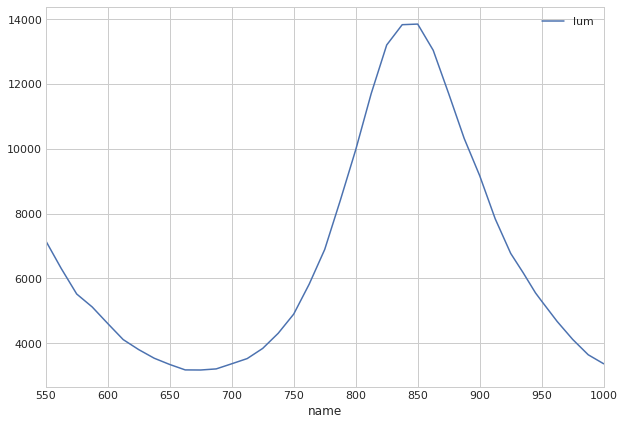

In [524]:
lum.plot(x='name', y='lum')

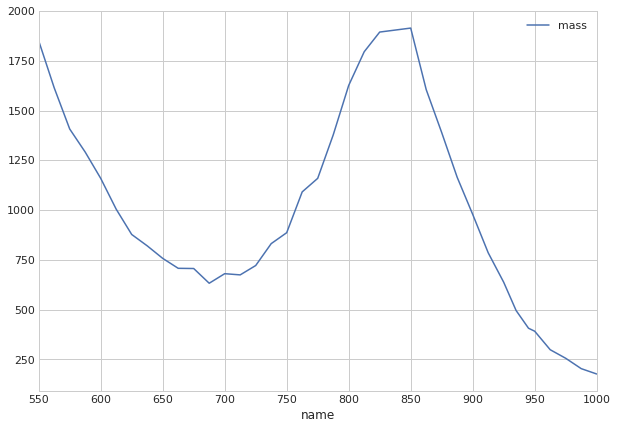

In [525]:
data_prep.groupby('name').agg({'mass':np.size}).plot()

In [526]:
data_prep.groupby('name').agg({'mass':np.size})

,mass
name,
550.0,1851.0
562.5,1615.0
575.0,1408.0
587.5,1292.0
600.0,1160.0
612.5,1005.0
625.0,878.0
637.5,821.0
650.0,758.0


Слияние точек

In [527]:
cnct = []
if year=='11':
    cnct = [([875., 887.5], 880), ([900., 912.5, 925.], 910), ([935., 945., 950., 962.5, 975., 987.5, 1000.], 950)] #11year
if year=='12':
    cnct = [([900., 920., 936., 950., 960., 970., 980., 990], 960)] #12 year
if year=='17':
    cnct = [([880., 890., 900., 910.], 900), ([920., 930., 936., 937.5], 935),
            ([937.4, 938.3, 938.9], 938), ([939.6, 940.2, 940.8], 940),
            ([942., 950., 960., 971.], 960), ([981., 990, 1003.5],990)] #17 year
if year=='19':
    cnct = [([862.5, 875.0, 887.5, 900.0, 912.5, 925], 875),([936, 945.0, 950.0, 951.1, 955.0, 962.5], 955),
            ([975., 978.0, 987.5], 980)] #19year

In [528]:
for c in cnct:
    data_prep.name.replace(c[0], c[1], inplace=True)

OK, points have been merged

In [529]:
data_prep.tail()

,name,lum,beam_energy,mass,trigger
38191,1000.0,3361,1000.0,488.678284,-1
38192,1000.0,3361,1000.0,502.696716,10
38193,1000.0,3361,1000.0,482.546844,0
38194,1000.0,3361,1000.0,489.826843,9
38195,1000.0,3361,1000.0,495.701385,0


In [530]:
check_foo(data_prep, data)

Good. 38196 rows


### Пересчитать светимости в слитых точках

In [531]:
data_prep['lume'] = data_prep.beam_energy*data_prep.lum

Проверить правильность слияния

In [532]:
#число в поле lum с количеством элементов в списке для слияния
data_prep[['lum', 'name']].\
drop_duplicates(subset=['name','lum']).groupby('name').agg({'lum':np.size}).query('lum!=1')

,lum
name,


In [533]:
new_lum = data_prep[['beam_energy', 'lum', 'lume', 'name']].drop_duplicates(subset=['lum','name']).\
groupby('name').agg({'lume':[np.sum], 'lum':[np.sum], 'beam_energy':[np.min, np.max]})

In [534]:
new_lum.shape

(38, 4)

In [535]:
new_lum['Emean'] = np.round( new_lum[('lume','sum')]/new_lum[('lum','sum')], 2)

In [536]:
new_lum.columns = ['lume', 'lum', 'dEmin', 'dEmax', 'Emean']
new_lum.drop('lume', axis=1, inplace=True)
new_lum['dEmax'] = np.abs( np.round( new_lum.dEmax-new_lum.Emean, 2) )
new_lum['dEmin'] = np.abs( np.round( new_lum.Emean - new_lum.dEmin, 2) )

In [537]:
#data.loc[641.].beam_energy.std()

In [538]:
new_lum.query('dEmin>0')

,lum,dEmin,dEmax,Emean
name,,,,


I have got new luminosity table.

Now I should join it to existing table

In [539]:
data_prep.drop(['lume', 'lum', 'beam_energy'], axis=1, inplace=True)

In [540]:
final_data = data_prep.join(new_lum, how='inner', on='name')

In [541]:
check_foo(final_data, data_prep)

Good. 38196 rows


That is good. Now I should do the analysis

In [542]:
final_data.tail()

,name,mass,trigger,lum,dEmin,dEmax,Emean
38191,1000.0,488.678284,-1,3361,0.0,0.0,1000.0
38192,1000.0,502.696716,10,3361,0.0,0.0,1000.0
38193,1000.0,482.546844,0,3361,0.0,0.0,1000.0
38194,1000.0,489.826843,9,3361,0.0,0.0,1000.0
38195,1000.0,495.701385,0,3361,0.0,0.0,1000.0


----------------
## Fit

In [543]:
data2 = final_data.groupby('name')

In [544]:
dic = {}
for i in data2.groups:
    print(i)
    dic[i] = np.array( data2.get_group(i)['mass'] )

550.0
562.5
575.0
587.5
600.0
612.5
625.0
637.5
650.0
662.5
675.0
687.5
700.0
712.5
725.0
737.5
750.0
762.5
775.0
787.5
800.0
812.5
825.0
837.5
850.0
862.5
875.0
887.5
900.0
912.5
925.0
935.0
945.0
950.0
962.5
975.0
987.5
1000.0


In [545]:
import iminuit
import probfit as pf

In [546]:
plt.rcParams.update({'font.size': 18, 'figure.figsize':(16,9)})

In [547]:
mass_bound = (450, 550)

In [548]:
#2 гаусса
def constant(x):
    return 1
def two_gauss(x, mu, sigma1, sigma2, frac):
    return frac*pf.gaussian(x, mu, sigma1) + (1-frac)*pf.gaussian(x, mu, sigma2)

norm_sig = pf.rename( pf.Normalized( two_gauss, mass_bound ), ['x', 'M', '$\sigma1$', '$\sigma2$', 'f'] )
norm_bkg = pf.Normalized( constant, mass_bound )

ext_sig = pf.Extended(norm_sig, extname='$N_{sig}$')
ext_bkg = pf.Extended(norm_bkg, extname='$N_{bkg}$')

pdf = pf.AddPdf(ext_sig, ext_bkg)

sigma1Lim = (5.43, 5.10)
sigma2Lim = (12.68, 0)
MLim = (497.299, 5.098)
fLim = (1, 0)

# 11: 𝜎1=(4.49, 0.27) , 𝜎2=(10.1, 1.), 𝑓=(0.68, 0.07), M=(497.299, 0.098)
# 12: 𝜎1=(5.26, 0.30) , 𝜎2=(14.42, 3.87), 𝑓=(0.86, 0.06), M=(498.33, 0.27)
# mod_old: 𝜎1=(5.43, 0.10) , 𝜎2=(12.68, 0.25), 𝑓=(0.58, 0.02), M=(497.05, 0.04)

limits = {
    "limit_M": [MLim[0]-MLim[1], MLim[0]+MLim[1]],
    "limit_$\sigma1$": [sigma1Lim[0] - sigma1Lim[1], sigma1Lim[0] + sigma1Lim[1]],
    "limit_$\sigma2$": [sigma2Lim[0] - sigma2Lim[1], sigma2Lim[0] + sigma2Lim[1]],
    "limit_$N_{sig}$": [0, 100000],
    "limit_$N_{bkg}$": [0, 2000],
    "limit_f": [fLim[0]-fLim[1], fLim[0]+fLim[1]]
}
errors = {
    "error_M": 1,
    "error_$\sigma1$": 0.1,
    "error_$\sigma2$": 0.,
    "error_$N_{sig}$": 0.3,
    "error_$N_{bkg}$": 0.1,
    "error_f": 0.05
}

# norm_sig1 = pf.Normalized( pf.rename(pf.gaussian, ['x', 'm', '$\sigma1$']), mass_bound)
# norm_sig2 = pf.Normalized( pf.rename(pf.gaussian, ['x', 'm', '$\sigma2$']), mass_bound)
# norm_bkg = pf.Extended(norm_bkg, extname='$N_{bkg}$')

# gauss1 = pf.Extended(norm_sig1, extname='$N_{sig1}$')
# gauss2 = pf.Extended(norm_sig2, extname='$N_{sig2}$')

# pdf = pf.AddPdf(gauss1, gauss2, norm_bkg)
pf.describe(pdf)

# limits = {"limit_m": [497.6, 497.6], "limit_$\sigma1$": [4.26, 4.26], "limit_$\sigma2$": [11.16, 11.16],  
#           "limit_$N_{sig1}$": [0, 10000], "limit_$N_{sig2}$": [0, 10000], "limit_$N_{bkg}$": [0, 1000]}
# errors = {"error_m": 1, "error_$\sigma1$": 0., "error_$\sigma2$": 0. , 
#           "error_$N_{sig1}$": 0.3, "error_$N_{sig2}$": 0.3, "error_$N_{bkg}$":0}

['x', 'M', '$\\sigma1$', '$\\sigma2$', 'f', '$N_{sig}$', '$N_{bkg}$']

In [549]:
def fitter(dic, nbins, energy, binnedLik=False, simple_plot=True):
    
    likelihood = pf.UnbinnedLH(pdf, dic, extended=True, extended_bound=mass_bound) if not(binnedLik) else \
    pf.BinnedLH(pdf, dic, int(nbins*(mass_bound[1]-mass_bound[0])/100.), bound=mass_bound, extended=True)
    
    initial_par_values = {"M": 497.6, "$\sigma1$": 4.26, "$N_{sig}$": np.size(dic),
                          "$\sigma2$": 11.16, "f": 0.5, "$N_{bkg}$": 1}
    mt = iminuit.Minuit(likelihood, **initial_par_values, **errors, **limits, pedantic=False)
    mt.migrad();
        
    if simple_plot:
        likelihood.draw(minuit=mt) if binnedLik else likelihood.draw(minuit=mt, bins=nbins, bound=mass_bound)
    else:
        fig = plt.figure(figsize=(16, 10), dpi= 80)
        grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

        # Define the axes
        ax_main = fig.add_subplot(grid[:-1, :])

        if binnedLik:
            likelihood.draw(minuit=mt)
        else:
            likelihood.draw(minuit=mt, bins=nbins, bound=mass_bound)

        plt.tick_params(labelsize=20);
        plt.xlabel('invariant mass, MeV', fontsize=20)
        plt.ylabel('number of events', fontsize=20)

        # this is an inset axes over the main axes
        ax_bottom = fig.add_subplot(grid[-1, :], xticklabels=[])
        likelihood.draw_residual(minuit=mt) if binnedLik else \
        likelihood.draw_residual(minuit=mt, bins=nbins, bound=mass_bound)
    
        plt.savefig(f'../outputs/{year}/figures/fit_e{energy}.png')
    return mt, likelihood

In [550]:
itr = iter(dic)

In [551]:
fit_frame = pd.DataFrame(columns=[ 'M', 'S1', 'S2', 'f', 'N', 'C', 
                                  'Merr', 'S1err', 'S2err', 'ferr', 'Nerr', 'Cerr'])

In [629]:
i = next(itr)
print('Label:', i)

Label: 1000.0


Migrad quality: True
Real: 177 Found: 177.00032947838073


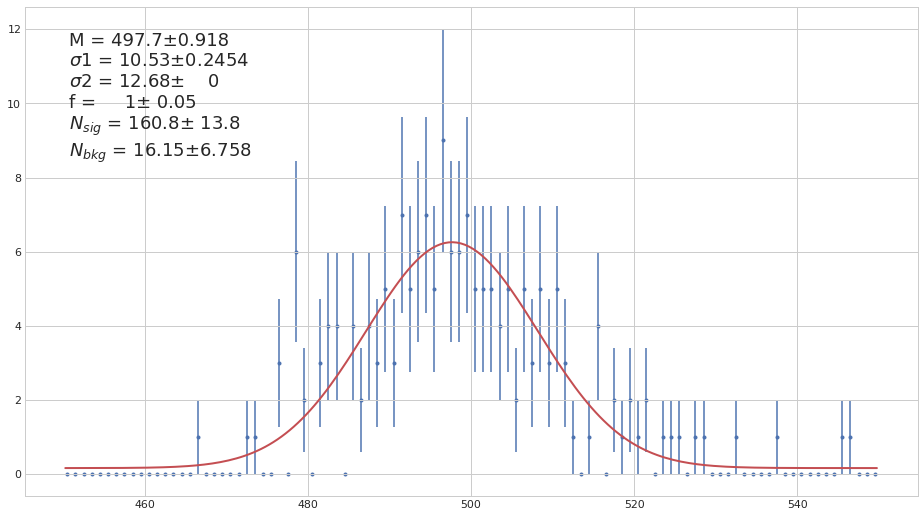

In [630]:
#mass_bound = (450, 550)
dicx = dic[i]#final_data.mass.values#dic[i]#
mt, lik = fitter(dicx, 100, i, False, True)
fit_frame.loc[i] = mt.values.values() + mt.errors.values()
print("Migrad quality:", mt.migrad_ok())
print( 'Real:', np.size(dicx), 'Found:', mt.values['$N_{sig}$'] + mt.values['$N_{bkg}$'] )

In [557]:
fit_frame

,M,S1,S2,f,N,C,Merr,S1err,S2err,ferr,Nerr,Cerr
550.0,496.573449,5.851739,12.68,1.0,1717.819541,132.977716,0.150478,0.134013,0.0,0.05,42.889934,15.957880
562.5,496.793035,6.394531,12.68,1.0,1497.609073,117.380679,0.176619,0.159453,0.0,0.05,40.260453,15.506115


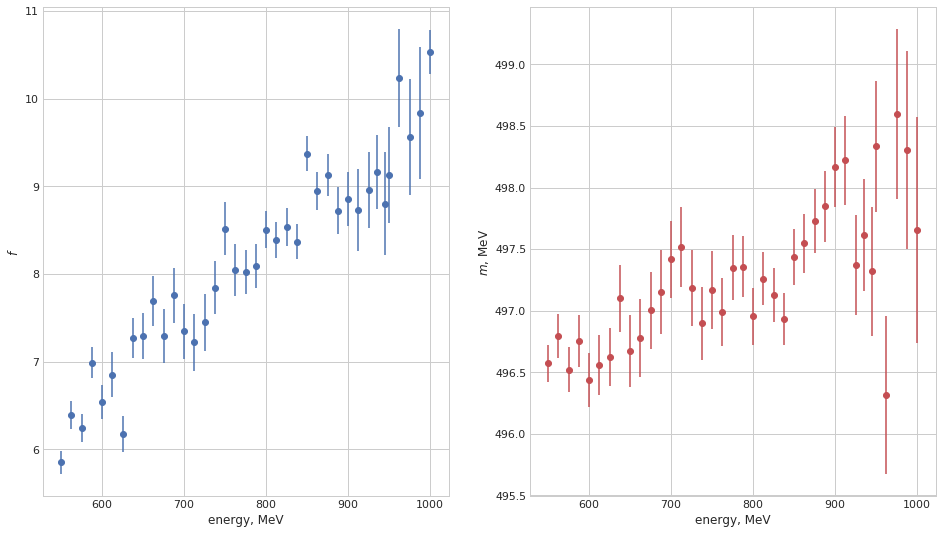

In [631]:
plt.subplot(1, 2, 1)
plt.errorbar(data=fit_frame, x=fit_frame.index, y='S1', yerr='S1err', fmt='o')
plt.xlabel('energy, MeV');
plt.ylabel('$f$');
plt.subplot(1, 2, 2)

plt.errorbar(x=fit_frame.index, y=fit_frame.M, yerr=fit_frame.Merr, fmt='or')
plt.xlabel('energy, MeV');
plt.ylabel('$m$, MeV');

### Some notes:
none

## Анализ $\sigma$

### 19 год

В точках 550 и 550.1 принципиально различается ширина ( 4.8 vs 6.12 )

В 19 году взял группами точки по энергии и посмотрел их $\sigma$, видно, что ширина растёт вместе с энергией

In [634]:
np.round(fit_frame.S1err.values, 2)

array([0.13, 0.16, 0.16, 0.18, 0.19, 0.25, 0.21, 0.23, 0.26, 0.28, 0.31,
       0.31, 0.31, 0.32, 0.32, 0.3 , 0.31, 0.29, 0.25, 0.25, 0.21, 0.2 ,
       0.21, 0.2 , 0.2 , 0.21, 0.24, 0.27, 0.31, 0.47, 0.44, 0.42, 0.59,
       0.55, 0.56, 0.66, 0.75, 0.25])

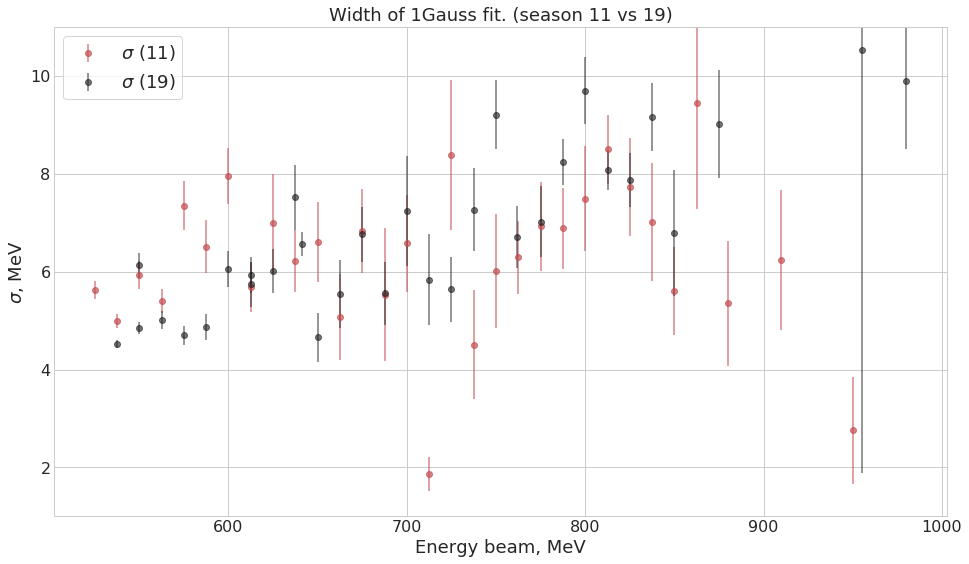

In [651]:
en19_an  = [537.5, 550. , 550.1, 562.5, 575. , 587.5, 600. , 612.5, 612.6,
       625. , 637.5, 641. , 650. , 662.5, 675. , 687.5, 700. , 712.5,
       725. , 737.5, 750. , 762. , 775. , 787.5, 800. , 812.5, 825. ,
       837.5, 850. , 875. , 955. , 980. ]
sigma19_an = [ 4.52,  4.85,  6.13,  5.01,  4.7 ,  4.87,  6.05,  5.74,  5.93,
        6.02,  7.52,  6.57,  4.66,  5.54,  6.76,  5.56,  7.24,  5.83,
        5.64,  7.27,  9.21,  6.71,  7.02,  8.25,  9.7 ,  8.08,  7.87,
        9.16,  6.79,  9.02, 10.53,  9.9 ]
dsigma19_an = [0.09, 0.13, 0.26, 0.18, 0.19, 0.26, 0.37, 0.46, 0.36, 0.45, 0.67,
       0.24, 0.5 , 0.69, 0.56, 0.64, 1.13, 0.93, 0.66, 0.84, 0.71, 0.63,
       0.73, 0.47, 0.69, 0.41, 0.55, 0.7 , 1.28, 1.1 , 8.64, 1.39]

enMC_an = [ 550. ,  562.5,  575. ,  587.5,  600. ,  612.5,  625. ,  637.5,
        650. ,  662.5,  675. ,  687.5,  700. ,  712.5,  725. ,  737.5,
        750. ,  762.5,  775. ,  787.5,  800. ,  812.5,  825. ,  837.5,
        850. ,  862.5,  875. ,  887.5,  900. ,  912.5,  925. ,  935. ,
        945. ,  950. ,  962.5,  975. ,  987.5, 1000. ]
sigmaMC_an = [5.5 , 5.87, 5.98, 6.3 , 6.23, 6.79, 6.33, 7.3 , 7.29, 7.54, 7.32,
       7.12, 7.39, 7.85, 7.59, 7.94, 7.64, 8.14, 7.99, 8.52, 8.4 , 8.44,
       8.51, 8.3 , 8.73, 8.77, 8.87, 8.3 , 8.95, 8.55, 9.21, 8.9 , 9.25,
       8.94, 9.4 , 9.67, 8.87, 8.95]
dsigmaMC_an = [0.12, 0.15, 0.17, 0.17, 0.21, 0.2 , 0.25, 0.29, 0.26, 0.34, 0.27,
       0.24, 0.32, 0.27, 0.33, 0.27, 0.23, 0.24, 0.23, 0.2 , 0.19, 0.18,
       0.15, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.23, 0.28, 0.24, 0.3 ,
       0.26, 0.29, 0.37, 0.36, 0.36]

enMCold_an = [ 550. ,  562.5,  575. ,  587.5,  600. ,  612.5,  625. ,  637.5,
        650. ,  662.5,  675. ,  687.5,  700. ,  712.5,  725. ,  737.5,
        750. ,  762.5,  775. ,  787.5,  800. ,  812.5,  825. ,  837.5,
        850. ,  862.5,  875. ,  887.5,  900. ,  912.5,  925. ,  935. ,
        945. ,  950. ,  962.5,  975. ,  987.5, 1000. ]
sigmaMCold_an = [ 5.85,  6.39,  6.24,  6.99,  6.54,  6.85,  6.17,  7.27,  7.29,
        7.7 ,  7.3 ,  7.76,  7.34,  7.22,  7.45,  7.84,  8.52,  8.05,
        8.02,  8.09,  8.5 ,  8.39,  8.54,  8.37,  9.37,  8.94,  9.12,
        8.72,  8.85,  8.73,  8.95,  9.16,  8.8 ,  9.12, 10.23,  9.56,
        9.83, 10.53]
dsigmaMCold_an = [0.13, 0.16, 0.16, 0.18, 0.19, 0.25, 0.21, 0.23, 0.26, 0.28, 0.31,
       0.31, 0.31, 0.32, 0.32, 0.3 , 0.31, 0.29, 0.25, 0.25, 0.21, 0.2 ,
       0.21, 0.2 , 0.2 , 0.21, 0.24, 0.27, 0.31, 0.47, 0.44, 0.42, 0.59,
       0.55, 0.56, 0.66, 0.75, 0.25]

en11_an = [525. , 537.5, 550. , 562.5, 575. , 587.5, 600. , 612.5, 625. ,
       637.5, 650. , 662.5, 675. , 687.5, 700. , 712.5, 725. , 737.5,
       750. , 762.5, 775. , 787.5, 800. , 812.5, 825. , 837.5, 850. ,
       862.5, 880. , 910. , 950. ]
sigma11_an = [5.63, 4.99, 5.93, 5.4 , 7.35, 6.51, 7.95, 5.69, 6.99, 6.22, 6.6 ,
       5.07, 6.83, 5.53, 6.58, 1.87, 8.38, 4.51, 6.01, 6.29, 6.93, 6.89,
       7.49, 8.5 , 7.73, 7.02, 5.61, 9.45, 5.35, 6.24, 2.76]
dsigma11_an = [0.18, 0.15, 0.28, 0.25, 0.5 , 0.54, 0.57, 0.51, 1.01, 0.63, 0.82,
       0.88, 0.85, 1.36, 0.99, 0.35, 1.53, 1.12, 1.16, 0.74, 0.91, 0.83,
       1.07, 0.7 , 1.01, 1.21, 0.9 , 2.16, 1.27, 1.43, 1.09]

df_sigma_an = pd.DataFrame({'emin':emin_an, 'emax':emax_an, 'sigma':sigma_an, 'ds': dsigma_an})
df_sigma_an['emean'] = (df_sigma_an.emin + df_sigma_an.emax)/2.
df_sigma_an['deup'] = df_sigma_an.emean - df_sigma_an.emin
# plt.errorbar(x=enMC_an, y=sigmaMC_an, yerr=dsigmaMC_an, fmt='o', alpha=0.8, label='$\sigma$ (MC)')
# plt.errorbar(x=enMCold_an, y=sigmaMCold_an, yerr=dsigmaMCold_an, alpha=0.8, fmt='oc', label='$\sigma$ (MC_old)')
plt.errorbar(x=en11_an, y=sigma11_an, yerr=dsigma11_an, fmt='or', alpha=0.7, label='$\sigma$ (11)')
plt.errorbar(x=en19_an, y=sigma19_an, yerr=dsigma19_an, fmt='ok', alpha=0.6, label='$\sigma$ (19)')
plt.legend(fontsize=18, frameon=True);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.ylim(1, 11)
plt.xlabel('Energy beam, MeV', fontsize=18);
plt.ylabel('$\sigma$, MeV', fontsize=18);
plt.title('Width of 1Gauss fit. (season 11 vs 19)', fontsize=18);
plt.savefig('sigma3.pdf')

Возникает гипотеза (ещё и с учётом того факта, что на большой статистике данные описываются не идеально) добавить ещё один гаусс. Посмотрим, что из этого выйдет.

Повторю распределение сигм по аналогии с картинкой выше

<ErrorbarContainer object of 3 artists>

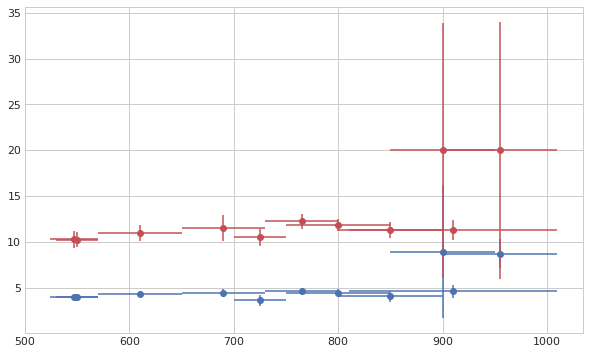

In [552]:
plt.rcParams.update({'font.size': 18, 'figure.figsize':(10,6)})
emin_an  = [524, 570, 650, 730, 800, 900, 850, 750, 700, 530, 810]
emax_an  = [570, 650, 730, 800, 900, 1010, 950, 850, 750, 570, 1010]
sigma1_an = [4.02, 4.31, 4.44, 4.66, 4.08, 8.724847949065675, 8.952093654550044, 4.509152675111134, 3.6841658856535178, 4.01709961911671, 4.628942053127934]
dsigma1_an = [0.13, 0.18, 0.44, 0.39, 0.55, 1.590062670581002, 7.270944904440277, 0.3453623743108212, 0.6048651400716212, 0.1190920659859942, 0.7016815273028718]
sigma2_an = [10.3, 10.98, 11.55, 12.25, 11.34, 19.995900427431625, 19.999882612152, 11.866375420268561, 10.53279261428423, 10.283255759137344, 11.339313291171166]
dsigma2_an = [0.9, 0.85, 1.42, 0.81, 0.89, 13.996992016425061, 13.933962567163773, 0.6617076556061905, 0.9474962757272731, 0.8289418695468278, 1.1023824322696134]
frac12_an = [3.92, 2.31, 1.76, 0.88, 0.64, 2.728843351319719, 6.911293728105318, 0.8379169741736125, 0.7006647553677061, 3.9196405944377877, 0.62839843050261]
df_sigma_an = pd.DataFrame({'emin':emin_an, 'emax':emax_an, 'sigma1':sigma1_an, 'ds1': dsigma1_an, 
                            'sigma2':sigma2_an, 'ds2': dsigma2_an, 'frac': frac12_an})
df_sigma_an['emean'] = (df_sigma_an.emin + df_sigma_an.emax)/2.
df_sigma_an['deup'] = df_sigma_an.emean - df_sigma_an.emin
plt.errorbar(data=df_sigma_an, x='emean', y='sigma1', xerr='deup', yerr='ds1', fmt='ob')
plt.errorbar(data=df_sigma_an, x='emean', y='sigma2', xerr='deup', yerr='ds2', fmt='or')

Видно, что каждая из сигм практически не сдвигается. Но видно, что на малом объёме данных ширины начинают расплываться (заметно при высоких энергиях)

Зафиксирую ширины на средних без учёта выпавших точек

In [238]:
print('Sigma1:', df_sigma_an.drop([5,6]).sigma1.mean() )
print('Sigma2:', df_sigma_an.drop([5,6]).sigma2.mean() )

Sigma1: 4.261040025889923
Sigma2: 11.160193009429035


Тогда проверяю предположение, что $\sigma$ в случае одного гаусса меняется из-за того, что меняется доля событий под узким и широким гауссами меняется с энергией

<ErrorbarContainer object of 3 artists>

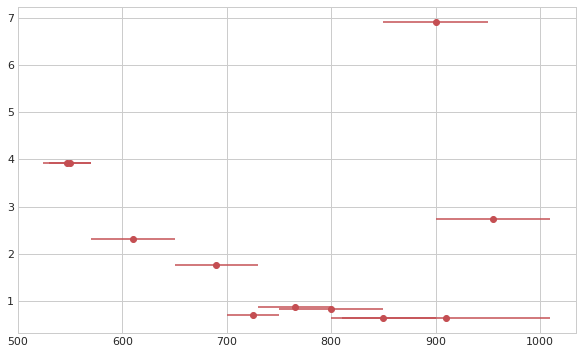

In [314]:
plt.errorbar(data=df_sigma_an, x='emean', y='frac', xerr='deup', fmt='or')

Теперь 2 гаусса для моделирования (`model_new`)

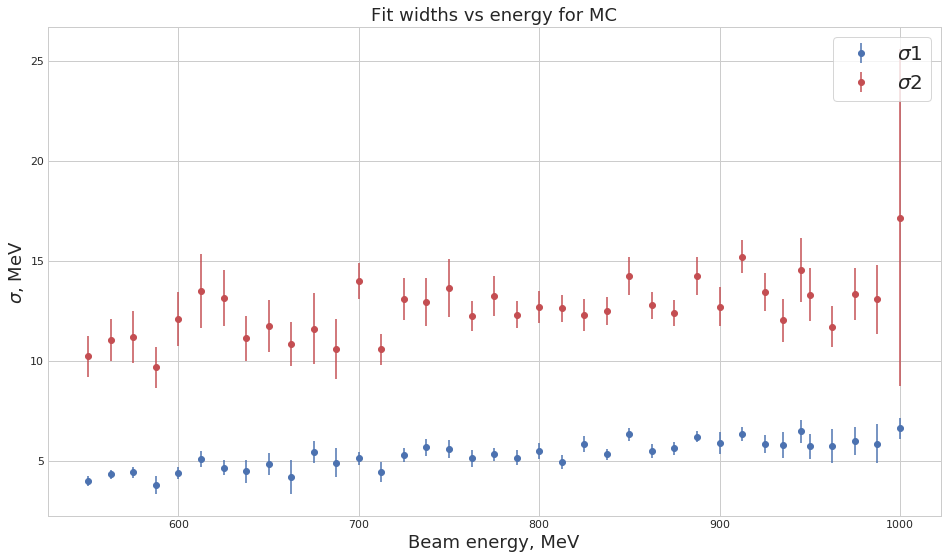

In [194]:
en_an = [ 550. ,  562.5,  575. ,  587.5,  600. ,  612.5,  625. ,  637.5,
        650. ,  662.5,  675. ,  687.5,  700. ,  712.5,  725. ,  737.5,
        750. ,  762.5,  775. ,  787.5,  800. ,  812.5,  825. ,  837.5,
        850. ,  862.5,  875. ,  887.5,  900. ,  912.5,  925. ,  935. ,
        945. ,  950. ,  962.5,  975. ,  987.5, 1000. ]
s1_an = [4.00928888, 4.33747255, 4.43559649, 3.803059  , 4.423181  ,
       5.1014904 , 4.66565474, 4.5045961 , 4.87810257, 4.1960529 ,
       5.43876272, 4.91843674, 5.14132747, 4.45975828, 5.31429813,
       5.69505078, 5.60314509, 5.14196975, 5.3540354 , 5.16952826,
       5.50877517, 4.94773543, 5.86872395, 5.33462472, 6.33305366,
       5.50748813, 5.64094449, 6.22043922, 5.8916277 , 6.35738374,
       5.86313576, 5.82890009, 6.48632741, 5.73844622, 5.75707775,
       6.0104084 , 5.87187928, 6.64138695]
s2_an = [10.24281036, 11.05319352, 11.18820377,  9.68060542, 12.08471558,
       13.48858781, 13.14961493, 11.13335416, 11.74951692, 10.83995468,
       11.62019776, 10.61195066, 13.99189698, 10.58376123, 13.09259816,
       12.95582443, 13.64101323, 12.22498239, 13.24488383, 12.3034521 ,
       12.69676957, 12.62291336, 12.27461984, 12.50987221, 14.22699406,
       12.77836884, 12.39655738, 14.23327043, 12.70892288, 15.21270754,
       13.44290652, 12.03170836, 14.54893378, 13.31082015, 11.72120822,
       13.3503376 , 13.0830581 , 17.15999921]
s1err_an = [0.24420247, 0.23628817, 0.2793554 , 0.43500637, 0.30562574,
       0.41426316, 0.36829545, 0.57240212, 0.55104936, 0.83858414,
       0.54760894, 0.72628265, 0.32523255, 0.51859386, 0.3644784 ,
       0.43592776, 0.44839775, 0.42269701, 0.32609865, 0.3645667 ,
       0.37670574, 0.36108701, 0.38803313, 0.29671017, 0.31075945,
       0.34238496, 0.33784375, 0.2866558 , 0.54865994, 0.35272085,
       0.43615359, 0.64643721, 0.55803832, 0.61537946, 0.86046785,
       0.71916831, 0.972075  , 0.51998215]
s2err_an = [1.02206463, 1.06032287, 1.28551181, 1.00666387, 1.33649728,
       1.83713476, 1.38658335, 1.13404142, 1.28373445, 1.08777375,
       1.78985585, 1.48944632, 0.89674085, 0.7724873 , 1.03681978,
       1.19733482, 1.46254629, 0.7502984 , 0.97471297, 0.6738531 ,
       0.78451445, 0.65602477, 0.80038106, 0.69198662, 0.94256228,
       0.66889848, 0.66153967, 0.94133285, 0.96653921, 0.84317584,
       0.94040895, 1.08274286, 1.57935263, 1.31951827, 1.03343693,
       1.29964889, 1.72233654, 8.39968307]
plt.errorbar(x=en_an, y=s1_an, yerr=s1err_an, fmt='ob', label='$\sigma1$')
plt.errorbar(x=en_an, y=s2_an, yerr=s2err_an, fmt='or', label='$\sigma2$')
plt.legend(frameon=True, fontsize=20);
plt.xlabel('Beam energy, MeV', fontsize=18);
plt.title('Fit widths vs energy for MC', fontsize=18)
plt.ylabel('$\sigma$, MeV', fontsize=18);
# plt.savefig('4.pdf')

По сигме всё более-менее хорошо, а вот следующее распределение по отношению событий в гауссах смущает.

Возможно это из-за каких-то разногласий моделирования и эксперимента, хотелось бы верить, но неизвестно

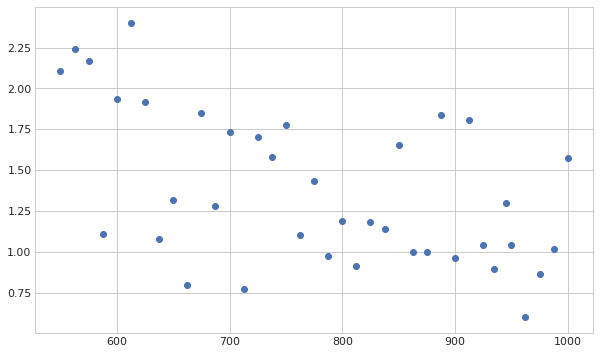

In [554]:
frac_an = [2.1047093 , 2.24281089, 2.16611316, 1.10671026, 1.93781416,
       2.39827954, 1.91504091, 1.07766751, 1.31920011, 0.79416602,
       1.84898383, 1.27802379, 1.73464467, 0.7721512 , 1.70095568,
       1.58280159, 1.77529039, 1.09981627, 1.43251272, 0.97705235,
       1.18825784, 0.9150671 , 1.18416207, 1.14115352, 1.6519543 ,
       0.99945712, 1.00099901, 1.83883042, 0.96433868, 1.8047252 ,
       1.04416522, 0.89545267, 1.29761692, 1.0409458 , 0.60057145,
       0.86444899, 1.01426618, 1.57182104]
plt.scatter(en_an, frac_an)

Смущает распределение по отношению гауссов, поэтому зафиксирую все параметры гауссов из полного распределения:

$\sigma_1 = 4.178 \pm 0.096$ , $\sigma_2 = 11.06 \pm 0.42$, $ f = 0.67 \pm 0.02$

### 17 год

Распределение по всем точкам даёт 
$\sigma_1 = 5.77 \pm 0.56$, $\sigma_2 = 13.44 \pm 2.12$, $f = 0.61 \pm 0.1 $, $M = 498.49 \pm 0.23$

### 11 год

Распределение по всем точкам даёт $\sigma_1 = 4.49 \pm 0.27$ , $\sigma_2 = 10.1 \pm 1.$, $ f = 0.68 \pm 0.07$. 

Я взял данные значения и разрешил им варьироваться в пределах ошибки

### 12 год

$\sigma_1 = 5.26 \pm 0.30$ , $\sigma_2 = 14.42 \pm 3.87$, $ f = 0.86 \pm 0.06$, $ M = 498.33 \pm 0.27$

### Model Old

$\sigma_1 = 5.43 \pm 0.10$ , $\sigma_2 = 12.68 \pm 0.25$, $ f = 0.58 \pm 0.02$, $ M = 497.05 \pm 0.04$

# Save fit info

In [175]:
fit_frame.to_csv(f'../outputs/{year}/tables/fit_frame.csv')

In [176]:
#mt.matrix(correlation=True)
#mt.draw_profile('Nsig');

In [177]:
dataN = fit_frame[['N','Nerr']]
dataN.columns = ['Nsig', 'dNsig']

In [178]:
dataN.tail()

,Nsig,dNsig
950.0,367.299743,20.583194
962.5,284.861876,18.049730
975.0,241.803154,16.820747
987.5,181.455364,14.965278
1000.0,154.283417,14.426290


I have got table with events numbers

Now, I will get rid of m-field in the data table (because, I have used it)

In [179]:
data_info = final_data.drop_duplicates(['name','lum']).drop(['mass', 'trigger'], axis=1).set_index('name')

In [180]:
dataN = data_info.join(dataN, how='inner')
dataN

,lum,dEmin,dEmax,Emean,Nsig,dNsig
name,,,,,,
550.0,7163,0.0,0.0,550.0,1831.236946,43.269959
562.5,6306,0.0,0.0,562.5,1582.495662,40.432597
575.0,5516,0.0,0.0,575.0,1387.568498,37.826418
587.5,5116,0.0,0.0,587.5,1276.300970,36.178258
600.0,4606,0.0,0.0,600.0,1126.567200,34.429073
612.5,4108,0.0,0.0,612.5,983.662227,32.020967
625.0,3799,0.0,0.0,625.0,864.431200,30.021147
637.5,3533,0.0,0.0,637.5,812.543718,28.826411
650.0,3340,0.0,0.0,650.0,733.937808,27.886360


In [181]:
check_foo(dataN, fit_frame)

Good. 38 rows


OK, save it

In [182]:
dataN.to_csv(f'../outputs/{year}/tables/signal_table{year}.csv', float_format='%.2f')

Ok, now about triggers

In [267]:
triggers = final_data[['trigger','name']].set_index('name')
triggers = triggers.assign(one = 1);

In [268]:
triggers

,trigger,one
name,,
640,0,1
640,0,1
640,2,1
640,0,1
640,0,1
...,...,...
960,0,1
960,0,1
960,0,1


In [269]:
check_foo(triggers, final_data)

Good. 629 rows


In [270]:
triggers = pd.pivot_table(triggers, values='one', columns=['trigger'], index='name', aggfunc=np.sum).fillna(0)

In [271]:
triggers.columns = ['TF', 'CF', 'TC']

In [272]:
triggers.head()

,TF,CF,TC
name,,,
640,66.0,0.0,31.0
680,47.0,2.0,21.0
720,33.0,2.0,18.0
760,50.0,1.0,25.0
800,67.0,2.0,47.0


In [273]:
def variance(k, n):
    return (k+1)*(k+2)/(n+2)/(n+3) - (k+1)**2/(n+2)**2

In [274]:
triggers['eTF'] = (triggers['TC'] + 1)/(triggers['CF'] + triggers['TC'] + 2)
triggers['eCF'] = (triggers['TC'] + 1)/(triggers['TF'] + triggers['TC'] + 2)
triggers['TrigEff'] = 1 - (1-triggers['eTF'])*(1-triggers['eCF'])

triggers['vTF'] = np.sqrt( variance(triggers['TC'], triggers['CF'] + triggers['TC']) )
triggers['vCF'] = np.sqrt( variance(triggers['TC'], triggers['TF'] + triggers['TC']) )
triggers['TrigErr'] = np.sqrt( np.square((1-triggers['eTF'])*triggers['vCF']) + 
                              np.square((1-triggers['eCF'])*triggers['vTF']) )

OK, trigers have been got

In [275]:
check_foo(triggers, dataN)

Good. 9 rows


In [276]:
triggers.to_csv(f'../outputs/{year}/tables/triggers{year}.csv', float_format='%.4f')

In [277]:
triggers

,TF,CF,TC,eTF,eCF,TrigEff,vTF,vCF,TrigErr
name,,,,,,,,,
640,66.0,0.0,31.0,0.969697,0.323232,0.979492,0.029398,0.046771,0.019946
680,47.0,2.0,21.0,0.880000,0.314286,0.917714,0.063730,0.055094,0.044198
720,33.0,2.0,18.0,0.863636,0.358491,0.912521,0.071557,0.065259,0.046759
760,50.0,1.0,25.0,0.928571,0.337662,0.952690,0.047824,0.053547,0.031906
800,67.0,2.0,47.0,0.941176,0.413793,0.965517,0.032629,0.045533,0.019314
840,53.0,2.0,41.0,0.933333,0.437500,0.962500,0.036778,0.050369,0.020959
860,17.0,4.0,13.0,0.736842,0.437500,0.851974,0.098465,0.086356,0.059867
880,9.0,0.0,8.0,0.900000,0.473684,0.947368,0.090453,0.111648,0.048899
960,34.0,10.0,26.0,0.710526,0.435484,0.836587,0.072621,0.062467,0.044807


### Check triggers

In [229]:
trig_data = pd.read_csv('../outputs/11/tables/triggers11.csv')

In [230]:
trig_data

,name,TF,CF,TC,eTF,eCF,TrigEff,vTF,vCF,TrigErr
0,525.0,319.0,384.0,154.0,0.29,0.33,0.52,0.02,0.02,0.02
1,537.5,510.0,20.0,393.0,0.95,0.44,0.97,0.01,0.02,0.01
2,550.0,235.0,62.0,103.0,0.62,0.31,0.74,0.04,0.02,0.03
3,562.5,237.0,9.0,170.0,0.94,0.42,0.97,0.02,0.02,0.01
4,575.0,97.0,27.0,45.0,0.62,0.32,0.74,0.06,0.04,0.04
5,587.5,107.0,4.0,76.0,0.94,0.42,0.96,0.03,0.04,0.02
6,600.0,45.0,25.0,27.0,0.52,0.38,0.70,0.07,0.06,0.05
7,612.5,75.0,4.0,52.0,0.91,0.41,0.95,0.04,0.04,0.02
8,625.0,27.0,3.0,13.0,0.78,0.33,0.85,0.10,0.07,0.07
9,637.5,49.0,0.0,27.0,0.97,0.36,0.98,0.03,0.05,0.02
